In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from matplotlib import font_manager,rc,rcParams
import platform

if platform.system() == 'Windows':
    path = 'c:/windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font',family = font_name)
elif platform.system() == 'Darwin':
    rc('font',family = 'AppleGothic')
else:
    print('Check your OS system')
    
rcParams['axes.unicode_minus'] = False

# Introduction
Convolutional Neural Network(CNNs)는 지난 몇년간 이미지 인식에 있어서 주요한 돌파구 중에 하나이다. 

수학에서 convolution이라는 것은 다른 함수의 결과물에 덧붙여 씌워지는 함수이다. 우리의 경우 이미지를 가로지르는 행렬 연산(필터)의 적용에 대해 살펴볼 것이다. 이러한 목적을 위해 이미지를 하나의 행렬로 생각하기로한다. 행렬의 숫자들은 픽셀 혹은 이미지 속성을 나타내는 것들이다.<br>
우리가 적용할 이런 convolutional 연산들은 이미지의 고정된 width의 filter를 이동하거나 결과를 출력하기 위해 element-wise하게 적용하는 것들을 포함한다.<br>
보통 Filter와 Max Pool의 aggregation으로써 진행된다.

# Implementing a simple CNN
MNIST digit 데이터에 대한 예측을 높이기 위해 네 개의 convolutional 신경망을 구성할 것이다. 처음 두 layer는 Covolution-ReLU-Max Pool로 이뤄져 있고 나머지 두 layer는 fully connected layer이다.

In [3]:
# 1.
from tensorflow import keras

In [4]:
mnist = keras.datasets.mnist

In [5]:
(X_train,y_train), (X_test,y_test) = mnist.load_data(path='mnist.npz')
# 흑백 스케일로 바꿔준다.
X_train = X_train/255
X_test = X_test/255

In [6]:
# 2. 3. 이미지가 grayscale이므로 depth(number of channels)가 1이다.
sess = tf.Session()

batch_size = 100
learning_rate = 0.005
evaluation_size = 500

image_width = X_train[0].shape[0]
image_height = X_train[0].shape[1]
target_size = max(y_train)+1

num_channels = 1
generations = 500
eval_every = 5

conv1_features = 25  # filter로 요약된 행렬을 25개의 층으로 갖는다는 의미. #5를 참고
conv2_features = 50
max_pool_size1 = 2
max_pool_size2 = 2
fully_connected_size1 = 100

In [7]:
# 4. training과 test data variable들에 대해 선언, 학습과 테스트에 대해서 다른 batch_size를 적용한다. 
x_input_shape = (batch_size,image_width,image_height,num_channels)
x_input = tf.placeholder(shape=x_input_shape,dtype=tf.float32)
y_target = tf.placeholder(shape=(batch_size),dtype=tf.int32)

eval_input_shape = (evaluation_size,image_width,image_height,num_channels)
eval_input = tf.placeholder(tf.float32,shape=eval_input_shape)
eval_target = tf.placeholder(tf.float32,shape=(evaluation_size))

In [8]:
# 5. convolution 층에 대한 weights와 biases
# filter : [filter_height, filter_width, in_channels, out_channels] 
conv1_weight = tf.Variable(tf.truncated_normal([4,4,num_channels,conv1_features],stddev=0.1,dtype=tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features],dtype=tf.float32))

conv2_weight = tf.Variable(tf.truncated_normal([4,4,conv1_features,conv2_features],stddev=0.1,dtype=tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features],dtype=tf.float32))

In [9]:
# 6. 완전연결층에 대한 weight와 bias
resulting_width = image_width//(max_pool_size1*max_pool_size2)
resulting_height = image_height//(max_pool_size1*max_pool_size2)

full1_input_size = resulting_width*resulting_height*conv2_features
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size,fully_connected_size1],stddev=0.1,dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1],stddev=0.1,dtype=tf.float32))

full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1,target_size],dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([target_size],stddev=0.1,dtype=tf.float32))

In [10]:
# 7.
def my_conv_net(input_data):
    # First Conv-ReLU-MaxPool layer
    conv1 = tf.nn.conv2d(input_data,conv1_weight,strides=[1,1,1,1],padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1,conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1,ksize=[1,max_pool_size1,max_pool_size1,1],
                               strides=[1,max_pool_size1,max_pool_size1,1],padding='SAME')
    # Second Conv-ReLU-MaxPool layer
    conv2 = tf.nn.conv2d(max_pool1,conv2_weight,strides=[1,1,1,1],padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2,conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2,ksize=[1,max_pool_size2,max_pool_size2,1],
                               strides=[1,max_pool_size2,max_pool_size2,1],padding='SAME')
    # Transform Output into a 1xN layer for next_fully connected layer
    final_conv_shape = max_pool2.get_shape().as_list()
    final_shape = final_conv_shape[1]*final_conv_shape[2]*final_conv_shape[3]
    flat_output = tf.reshape(max_pool2,shape = [final_conv_shape[0],final_shape])
    
    # First Fully Connected layer
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output,full1_weight),full1_bias))
    # Second Fully Connected layer
    final_model_output =tf.add(tf.matmul(fully_connected1,full2_weight),full2_bias)
    return final_model_output

In [11]:
# 8.
model_output = my_conv_net(x_input)
test_model_output = my_conv_net(eval_input)

# 9.
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output,labels=y_target))

# 10.
prediction = tf.nn.softmax(model_output)
test_prediction = tf.nn.softmax(test_model_output)
def get_accuracy(logits,targets):
    batch_predictions = np.argmax(logits,axis=1)
    num_correct = np.sum(np.equal(batch_predictions,targets))
    return 100.*num_correct/batch_predictions.shape[0]

In [12]:
# 11.
my_optimizer = tf.train.MomentumOptimizer(learning_rate,0.9)
train_step = my_optimizer.minimize(loss)

In [13]:
# 12.
init = tf.global_variables_initializer()
sess.run(init)

train_loss = []
train_acc = []
test_acc = []
for i in range(generations):
    rand_index = np.random.choice(len(X_train),size=batch_size)
    rand_x = np.expand_dims(X_train[rand_index],3).reshape(x_input_shape)
    rand_y = y_train[rand_index].reshape(batch_size)
    train_dict = {x_input:rand_x,y_target:rand_y}
    sess.run(train_step,feed_dict=train_dict)
    
    temp_train_loss,temp_train_preds = sess.run([loss,prediction],feed_dict=train_dict)
    temp_train_acc = get_accuracy(temp_train_preds,rand_y)
    if (i+1)%eval_every == 0:
        eval_index = np.random.choice(len(X_test),size=evaluation_size)
        eval_x = np.expand_dims(X_test[eval_index],3).reshape(eval_input_shape)
        eval_y = y_test[eval_index].reshape(evaluation_size)
        test_dict = {eval_input:eval_x,eval_target:eval_y}
        test_preds = sess.run(test_prediction,feed_dict=test_dict)
        temp_test_acc = get_accuracy(test_preds,eval_y)
        
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
        
        if (i+1)%50==0:
            print('Generation # {}, Train Loss: {}, Train Acc: {}, Test_acc : {}'\
                  .format(i+1,temp_train_loss,temp_train_acc,temp_test_acc))

Generation # 50, Train Loss: 0.31083548069000244, Train Acc: 89.0, Test_acc : 85.0
Generation # 100, Train Loss: 0.23121514916419983, Train Acc: 92.0, Test_acc : 93.4
Generation # 150, Train Loss: 0.2997101843357086, Train Acc: 91.0, Test_acc : 93.8
Generation # 200, Train Loss: 0.032414790242910385, Train Acc: 99.0, Test_acc : 95.0
Generation # 250, Train Loss: 0.13848018646240234, Train Acc: 96.0, Test_acc : 95.4
Generation # 300, Train Loss: 0.05913383513689041, Train Acc: 97.0, Test_acc : 96.0
Generation # 350, Train Loss: 0.13581033051013947, Train Acc: 95.0, Test_acc : 96.6
Generation # 400, Train Loss: 0.15678131580352783, Train Acc: 97.0, Test_acc : 95.8
Generation # 450, Train Loss: 0.12035210430622101, Train Acc: 96.0, Test_acc : 96.4
Generation # 500, Train Loss: 0.05856842175126076, Train Acc: 98.0, Test_acc : 97.6


No handles with labels found to put in legend.


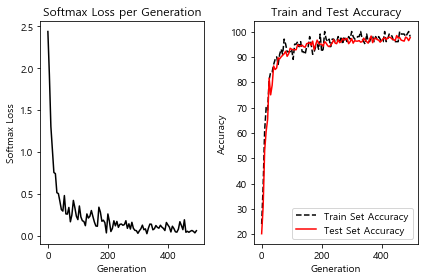

In [16]:
eval_indices = range(0,generations,eval_every)
fig,ax = plt.subplots(1,2)

ax[0].plot(eval_indices,train_loss,'k-')
ax[0].set_title('Softmax Loss per Generation')
ax[0].set_xlabel('Generation')
ax[0].set_ylabel('Softmax Loss')
ax[1].legend(loc='best')

ax[1].plot(eval_indices,train_acc,'k--',label='Train Set Accuracy')
ax[1].plot(eval_indices,test_acc,'r-',label='Test Set Accuracy')
ax[1].set_title('Train and Test Accuracy')
ax[1].set_xlabel('Generation')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best')

plt.tight_layout()

# Implementing an advanced CNN
신경망의 깊이를 늘리는 것은 CNN 모델을 이미지 인식으로 확장시키는 것에 매우 중요하다. 만일 충분한 데이터가 있다면 모델 예측의 정확도는 높아질 것이다. CNN 모델의 깊이를 늘리는 것은 표준화된 방식이 있는데 convolution, max pool, ReLU를 세트로 만족할만한 성과가 나오는 깊이까지 확장하는 것이다. 

CIFAR 10 데이터를 이용해 CNN을 사용해보기로 한다. 32x32사이즈의 이미지가 10개의 클래스로 나뉜다.

대부분의 이미지는 메모리에 fit하기에 너무 큰 경우가 많다. 텐서플로우를 통해 할 수 있는 것은 파일로부터 한번에 한개의 배치만을 읽어오는 파이프라인을 세팅하는 것이다. 이런 것을 하기 위해 image reader를 세팅하고 image reader에서 동작하는 batch queue를 만들기로한다.

또 이미지 인식에 있어서 학습을 위해 이미지를 보내기 이전에 무작위로 perturb(동요하게 하다?)하는 것이 일반적이다. 우리는 무작위로 crop하고 flip하고 밝기를 변화시키도록 한다.

In [3]:
# 1. 
import os
import tarfile
from six.moves import urllib
sess = tf.Session()

In [4]:
# 2. 모델 파라미터를 정의
batch_size = 128
output_every = 50
generations = 20000
eval_every = 500
image_height = 32
image_width = 32

crop_height = 24
crop_width = 24

num_channels = 3   # red, green, blue
num_targets = 10

data_dir = 'temp'
extract_folder = 'cifar-10-batches-bin'

In [5]:
# 3. learning rate를 점차적으로 (exponentially하게) 줄여나갈 것이다. 0.1*(0.9^(x/250)), x는 현재 generation number,
# 기본적으로 연속적으로 줄여나가게 되지만 텐서플로우는 계산의 형태로 인자를 받는다.
learning_rate = 0.1
lr_decay = 0.9
num_gens_to_wait = 250.

# 4. binary CIFAR-10 image를 읽을 수 있게 파라미터 설정
image_vec_length = image_height * image_width * num_channels
record_length = 1+image_vec_length

In [19]:
os.makedirs('temp')

In [21]:
# 5.CIFAR-10 이미지를 다운 받을 url과 디렉토리

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
cifar10_url = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'
data_file = os.path.join(data_dir,'cifat-10-binary.tar.gz')
if not os.path.isfile(data_file):
    # Download file
    filepath,_ = urllib.request.urlretrieve(cifar10_url,data_file)

In [22]:
# 압축풀기
tarfile.open(filepath,'r:gz').extractall(data_dir)

In [13]:
# 6. record reader를 세팅하고 무작위적으로 distorted된 이미지를 반환하는 함수
def read_cifar_files(filename_queue,distorted_images=True):
    reader = tf.FixedLengthRecordReader(record_bytes=record_length)
    key, record_string = reader.read(filename_queue)
    record_bytes = tf.decode_raw(input_bytes = record_string, out_type=tf.uint8)
    # Extract Label
    image_label = tf.cast(tf.slice(record_bytes, [0],[1]),tf.int32)
    # Extract Image
    image_extracted = tf.reshape(tf.slice(record_bytes,[1],[image_vec_length]),[num_channels,image_height,image_width])
    # Reshape image
    image_unit8image = tf.transpose(image_extracted,[1,2,0])
    reshaped_image = tf.cast(image_unit8image, tf.float32)
    # Randomly Crop image
    final_image = tf.image.resize_image_with_crop_or_pad(reshaped_image,crop_width,crop_height)
    
    if distorted_images:
        # Randomly flip the image horizontally, change the brightness and contrast
        final_image = tf.image.random_flip_left_right(final_image)
        final_image = tf.image.random_brightness(final_image,max_delta=63)
        final_image = tf.image.random_contrast(final_image,lower=0.2,upper=1.8)
    
    # Normalize whitening
    final_image = tf.image.per_image_standardization(final_image)
    return final_image, image_label

In [7]:
# 7. 배치 프로세서에 대해 이미지 파이프라인을 채우는 함수를 선언
# 우선 읽어들이고자 하는 파일 리스트를 세팅, 
# 텐서플로우 내장함수를 통해 생성된 input producer object로 이미지를 읽을 방법을 설정해야한다.
# input producer가 위에서 정의한 함수(read_cifar_files)를 통해 전해지면, batch reader를 queue에서 정의한다.(shuffle_batch() 통해)
def input_pipeline(batch_size, train_logical=True):
    if train_logical:
        files = [os.path.join(data_dir,extract_folder,'data_batch_{}.bin'.format(i)) for i in range(1,6)]
    else:
        files = [os.path.join(data_dir,extract_folder,'test_batch.bin')]
    filename_queue = tf.train.string_input_producer(files)
    image, label = read_cifar_files(filename_queue)
    min_after_dequeue = 1000  # 설정이 매우 중요. 샘플링에 관한 이미지 버퍼의 최소 사이즈로서 역할
    capacity = min_after_dequeue +3*batch_size
    example_batch, label_batch = tf.train.shuffle_batch([image,label], batch_size,capacity,min_after_dequeue)
    return example_batch, label_batch

In [18]:
# 8. 모델 함수를 정의, 두 개의 convolutional layer와 세 개의 fully-connected layer
# 변수 선언을 더 쉽게 하기 위해 두 개의 variable function을 선언한다. 
# 두 convolutional 층은 각각 64개의 feature를 생성한다. 
# 첫 번째 완전 연결층은 384개의 은닉 노드를 가지고 두 번째 convolutional layer와 연결된다.
# 두 번째 완전 연결층은 384개의 노드를 192개의 노드로 연결한다. 
# 마지막 완전 연결층은 192개의 노드를 우리가 예측하려하는 10개의 클래스로 연결한다.

def cifar_cnn_model(input_images, batch_size, train_logical=True):
    def truncated_normal_var(name,shape,dtype):
        return tf.get_variable(name=name, shape=shape, dtype=dtype,
                              initializer=tf.truncated_normal_initializer(stddev=0.05))
    def zero_var(name,shape,dtype):
        return tf.get_variable(name=name, shape=shape, dtype=dtype,
                               initializer=tf.constant_initializer(0.0))
    # First Convolutional Layer
    with tf.variable_scope('conv1') as scope:
        # Conv_kernel is 5x5 for all 3 colors and we will create 64 features(3개의 특징을 받아 64개를 반환하는 5x5모양 필터)
        conv1_kernel = truncated_normal_var(name='conv_kernel1',shape=[5,5,3,64],dtype=tf.float32)
        # We convolve across the image with a stride size of 1
        conv1 = tf.nn.conv2d(input_images,conv1_kernel,strides=[1,1,1,1],padding='SAME')
        # Initialize and add the bias term
        conv1_bias = zero_var(name='conv_bias1',shape=[64],dtype=tf.float32)
        conv1_add_bias = tf.nn.bias_add(conv1, conv1_bias)
        # ReLU element wise
        relu_conv1 = tf.nn.relu(conv1_add_bias)
        
    # Max Pooling
    pool1 = tf.nn.max_pool(relu_conv1, ksize=[1,3,3,1],strides=[1,2,2,1],padding='SAME',name='pool_layer1')
    # Local Response Normalization
    norm1 = tf.nn.lrn(pool1,depth_radius=5,bias=2.0,alpha=1e-3,beta=0.75,name='norm1')
    
    # Second Convolutional Layer
    with tf.variable_scope('conv2') as scope:
        # Conv kernel is 5x5, across all prior 64 features and we create 64 more features
        conv2_kernel = truncated_normal_var(name='conv_kernel2',shape=[5,5,64,64],dtype=tf.float32)
        # Convolve filter across prior output with stride size of 1
        conv2 = tf.nn.conv2d(norm1,conv2_kernel,strides=[1,1,1,1],padding='SAME')
        # Initialize and add the bias
        conv2_bias = zero_var(name='conv_bias2',shape=[64],dtype=tf.float32)
        conv2_add_bias = tf.nn.bias_add(conv2,conv2_bias)
        # ReLU element wise
        relu_conv2 = tf.nn.relu(conv2_add_bias)
    
    # Max Pooling
    pool2 = tf.nn.max_pool(relu_conv2, ksize=[1,3,3,1],strides=[1,2,2,1],padding='SAME',name='pool_layer2')
    # Local Response Normalization (parameters from paper)
    norm2 = tf.nn.lrn(pool2,depth_radius=5, bias=2.0,alpha=1e-3,beta=0.75,name='norm2')
    
    # Reshape output into a single matrix for multiplication for the fullt connected layers
    reshaped_output = tf.reshape(norm2 ,[batch_size,-1])
    reshaped_dim = reshaped_output.get_shape()[1].value
    
    # First Fully Connected Layer
    with tf.variable_scope('full1') as scope:
        # Fully connected layer will have 384 outputs
        full_weight1 = truncated_normal_var(name='full_mult1',shape=[reshaped_dim,384],dtype=tf.float32)
        full_bias1 = zero_var(name='full_bias1',shape=[384],dtype=tf.float32)
        full_layer1 = tf.nn.relu(tf.add(tf.matmul(reshaped_output,full_weight1),full_bias1))
        
    # Second Fully Connected Layer
    with tf.variable_scope('full2') as scope:
        # Second fully connected layer has 192 outputs
        full_weight2 = truncated_normal_var(name='full_mult2',shape=[384,192],dtype=tf.float32)
        full_bias2 = zero_var(name='full_bias2',shape=[192],dtype=tf.float32)
        full_layer2 = tf.nn.relu(tf.add(tf.matmul(full_layer1,full_weight2),full_bias2))
    
    # Final Fullt connected layer -> 10 categories for outputs
    with tf.variable_scope('full3') as scope:
        # Finally fully connected layer has 10 outputs
        full_weight3 = truncated_normal_var(name='full_mult3',shape=[192,num_targets],dtype=tf.float32)
        full_bias3 = zero_var(name='full_bias3',shape=[num_targets],dtype=tf.float32)
        final_output = tf.add(tf.matmul(full_layer2,full_weight3),full_bias3)
        
        return final_output

In [19]:
# 9. loss 함수 정의
def cifar_loss(logits,targets):
    # 필요없는 차원을 제거하고 타겟을 정수로 cast
    targets = tf.squeeze(tf.cast(targets, tf.int32))
    # 
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=targets)
    # 배치 사이즈네서 loss의 평균을 계산
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    return cross_entropy_mean

# 10. train_step을 정의, learing_rate가 점차적으로 줄어들 것(지수적으로)
def train_step(loss_value,generation_num):
    # Our learning rate is an exponential decay (stepped down)
    # 위에서 해당 파라미터들은 이미 정의
    model_learning_rate = tf.train.exponential_decay(learning_rate,generation_num,num_gens_to_wait,
                                                    lr_decay,staircase=True)
    # 
    my_optimizer = tf.train.GradientDescentOptimizer(model_learing_rate)
    #
    train_step = my_optimizer.minimize(loss_value)
    
    return train_step

# 11. accuracy를 계산하는 함수, train과 test에 대해 각각 수행할 것
def accuracy_of_batch(logits,targets):
    # Make sure targets are integers and drop extra dimensions
    targets = tf.squeeze(tf.cast(targets,tf.int32))
    # Get predicted values by finding which logits is greatest
    batch_predictions = tf.cast(tf.argmax(logits,1),tf.int32)
    # Check if they are equal across the batch
    predicted_correctly = tf.equal(batch_predictions,targets)
    # Average the 1's and 0's across the batch size
    accuracy = tf.reduce_meam(tf.cast(predicted_correctly,tf.float32))
    
    return accuracy

In [ ]:
# 12. image_pipeline function을 이용해 train과 test image pipeline을 각각 구축
images, targets = input_pipeline(batch_size,train_logical=True)
test_image,test_image = input_pipeline(batch_size,train_logical=False)

# 13. 학습 output과 테스트 output에 대한 모델을 초기화할 것이다. 
# 중요한 것은 모델을 학습시킨뒤 테스트 네트워크 선언시 
# scope.reuse_variables()를 선언함으로써 같은 모델 파리미터를 사용하게 하는 것이다.

with tf.variable_scope('model_definition') as scope:
    # Declare the training network model
    model_output = cifar_cnn_model(images,batch_size)
    # Use same variables within scope
    scope.reuse_variables()
    # Declare test model output
    test_output = cifar_cnn_model(test_images, batch_size)
    